# MITGCM Scale Analysis 

**Purpose**: Code for preforming the spatial scale analysis. I will be preformed this analysis on zonal and meridional spatial transects on, off, and in the transition region of the shelf. 

**Luke Colosi | lcolosi@ucsd.edu**

Force matplotlib plots to display directly within the output cell of the notebook

In [1]:
%matplotlib inline

Import python libraries

In [2]:
import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
from netCDF4 import Dataset, num2date
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
from scipy.interpolate import interp1d

# Set path to access python functions
sys.path.append("/home/lcolosi/AirSeaCoupling/tools/")

#--- Other Functions ---# 
import cartopy_figs as cart
from autocorr import compute_autocorr, compute_decor_scale
from spectra import spectra_autocov

Set data analysis parameters

In [13]:
# Set processing parameters
option_plot          = 0      # Specifies if supplementary plots are plotted
option_var           = 'temp' # Specifies which variable will analyzed. Options include: temp, sal, density

# Set time and space parameters
estimator    = 'biased'                      # Specifies the approach for estimating the autocorrelation function   
lon_point = -122 % 360                       # Specifies the longitude point of the time record 
lat_point = 34.25                               # Specifies the latitude point of the time record 

# Set path to project directory
PATH = "/data/SO3/lcolosi/mitgcm/SWOT_MARA_RUN4_LY/"
PATH_figs = "/home/lcolosi/AirSeaCoupling/figs_server/mitgcm/scale_analysis/"

# Set plotting parameters 
fontsize = 16

Load mitgcm data netcdf files 

In [14]:
#--- MITgcm Data ---# 
if option_var == 'temp':
    filename = PATH + "THETA_CCS4_hrly_ts_ext.nc"
elif option_var == 'sal':
    filename = PATH + "SALT_CCS4_hrly_ts_ext.nc"
elif option_var == 'density':
    filename = PATH + "RHO_CCS4_hrly_ts_ext.nc"
nc = Dataset(filename, 'r')

# Extract data variables
water_depth   = nc.variables['Depth'][:]

lon = nc.variables['XC'][:]
lat = nc.variables['YC'][:]
time =  num2date(nc.variables['time'][:], nc.variables['time'].units)

if option_var == 'temp':
    data = nc.variables['THETA'][:]
elif option_var == 'sal':
    data = nc.variables['SALT'][:]
elif option_var == 'density':
    data = nc.variables['RHO'][:]

# Convert cftime.DatetimeGregorian to Python datetime objects
time_dt = np.array([datetime(d.year, d.month, d.day, d.hour, d.minute, d.second) for d in time])

Obtain the zonal and meridional sections

In [21]:
# Find the spatial indices of the longitude and latitude point
idx_m = np.argmin(np.abs(lon - lon_point))
idx_z = np.argmin(np.abs(lat - lat_point))

# Extract data 
data_z = data[:,idx_z,:]
data_m = data[:,:,idx_m] 

Plot the spatial domain

/home/lcolosi/miniconda3/envs/ccs_scale/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1646: UserWarning: The following kwargs were not used by contour: 'shading'
  result = super().contourf(*args, **kwargs)
/tmp/ipykernel_3133924/2967300723.py:69: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  axes.plot(lon_point*np.ones((len(lat),)), lat, '-', transform=ccrs.PlateCarree(),
/tmp/ipykernel_3133924/2967300723.py:72: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  axes.plot(lon, lat_point*np.ones((len(lon),)), '-', transform=ccrs.PlateCarree(),


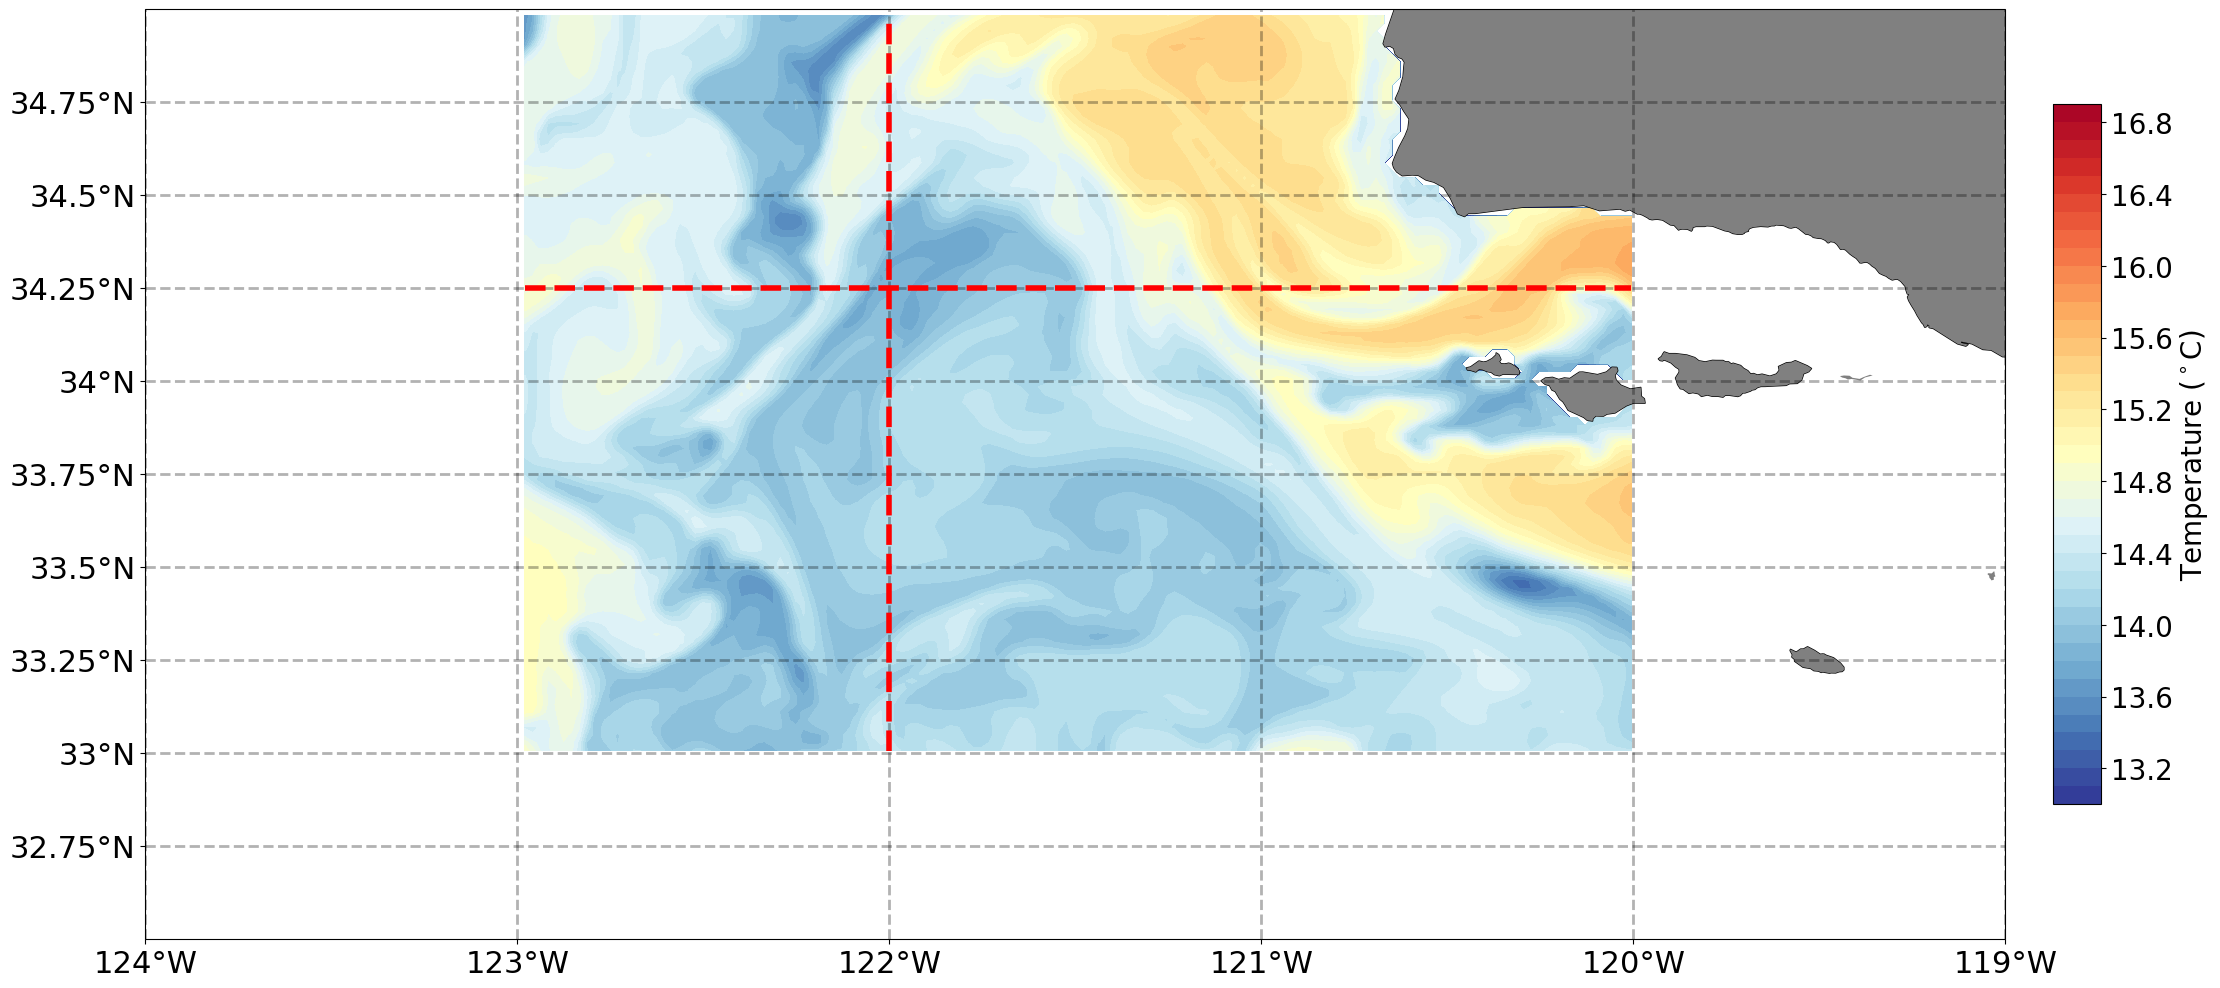

In [22]:
# Set plotting parameters
projection = ccrs.PlateCarree(central_longitude=0.0)
xticks = [-124, -123, -122, -121, -120, -119]
yticks = [32.75, 33.00, 33.25, 33.50, 33.75, 34.00, 34.25, 34.50, 34.75,]
resolution = "10m"
bounds = np.arange(0,360+40,40)
lon_min = -124
lon_max = -119
lat_min = 32.50
lat_max = 35

# Specify data specific attributes 
if option_var == 'temp':
    cmap = 'RdYlBu_r'
    label = r'Temperature ($^\circ$C)'
    levels = np.arange(13,17,0.1)
elif option_var == 'sal':
    cmap = 'BrBG_r'
    label = r'Salinity (psu)'
    levels = np.arange(32.85,33.75 + 0.02,0.02)
elif option_var == 'density': 
    cmap = 'Spectral_r'
    label = r'$\sigma_0$ (kg m$^{-3}$)'
    levels = np.arange(32.85,33.75 + 0.02,0.02)

# Create figure
fig, axes = plt.subplots(1,1, figsize=(24, 20), subplot_kw={"projection": projection})

# Set figure axes 
cart.set_subplots(axes, projection, resolution, lon_min=-124, lon_max=-119, lat_min=32.50, lat_max=35) 

# Plot potential temperature
mesh = axes.contourf(
    lon, lat, data[1,:,:], levels=levels,
    transform=ccrs.PlateCarree(),
    cmap=cmap,  
    shading="auto"
)

# Set grid ticks 
cart.set_grid_ticks(
    axes,
    projection=ccrs.PlateCarree(),
    xticks=xticks,
    yticks=yticks,
    xlabels=True,
    ylabels=True,
    grid=True,
    fontsize=22,
    color="black",
)

# Create colormap
cax = plt.axes([0.92, 0.33, 0.02, 0.35])
cart.set_cbar(
    mesh,
    cax,
    fig,
    orientation="vertical",
    extend="neither",
    cbar_label=label,
    nbins=10,
    fontsize=20,
    cbar_ticks=[],
    task="regular",
)

# Plot the 
axes.plot(lon_point*np.ones((len(lat),)), lat, '-', transform=ccrs.PlateCarree(), 
          color='red', linestyle='dashed',linewidth=4)

axes.plot(lon, lat_point*np.ones((len(lon),)), '-', transform=ccrs.PlateCarree(), 
          color='red', linestyle='dashed',linewidth=4)

# Show the plot
plt.show()

Plot the hovmuller plot

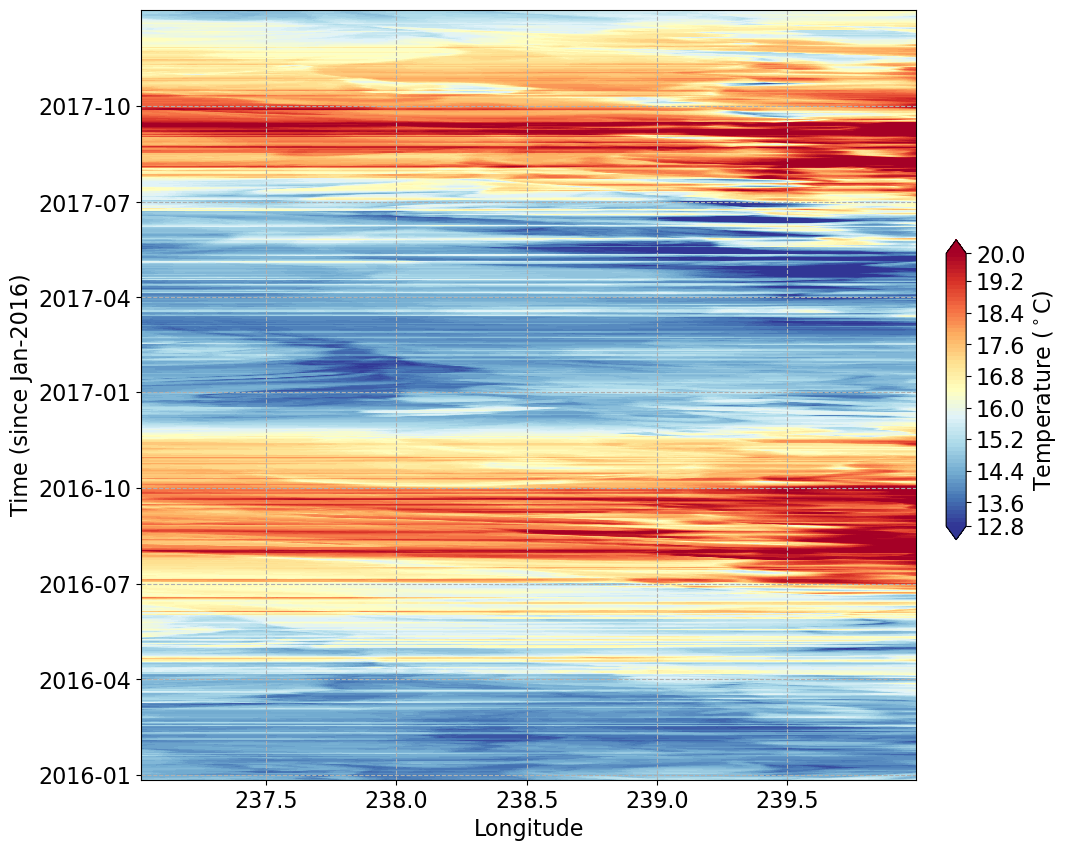

In [23]:
# Specify data specific attributes 
if option_var == 'temp':
    levels = np.arange(13,20,0.1)
elif option_var == 'sal':
    levels = np.arange(32.85,33.75 + 0.02,0.02)
elif option_var == 'density': 
    levels = np.arange(32.85,33.75 + 0.02,0.02)

# Set the fontsize
plt.rcParams.update({'font.size': fontsize})

# Create figure
fig, axes = plt.subplots(1,1, figsize=(10, 10))

# Plot zonal temperature
ctf = axes.contourf(lon,time_dt,data_z,cmap='RdYlBu_r',levels=levels,extend='both')

# Create colorbar
cax = plt.axes([0.93, 0.35, 0.02, 0.3])
cart.set_cbar(
    ctf,
    cax,
    fig,
    orientation="vertical",
    extend="both",
    cbar_label=label,
    nbins=10,
    fontsize=fontsize,
    cbar_ticks=[],
    task="regular",
)

# Set the figure attributes 
axes.set_xlabel('Longitude')
axes.set_ylabel('Time (since Jan-2016)')
#axes.set_ylim([time_dt[0], time_dt[8000]])
axes.grid(True, linestyle='--')
plt.show()

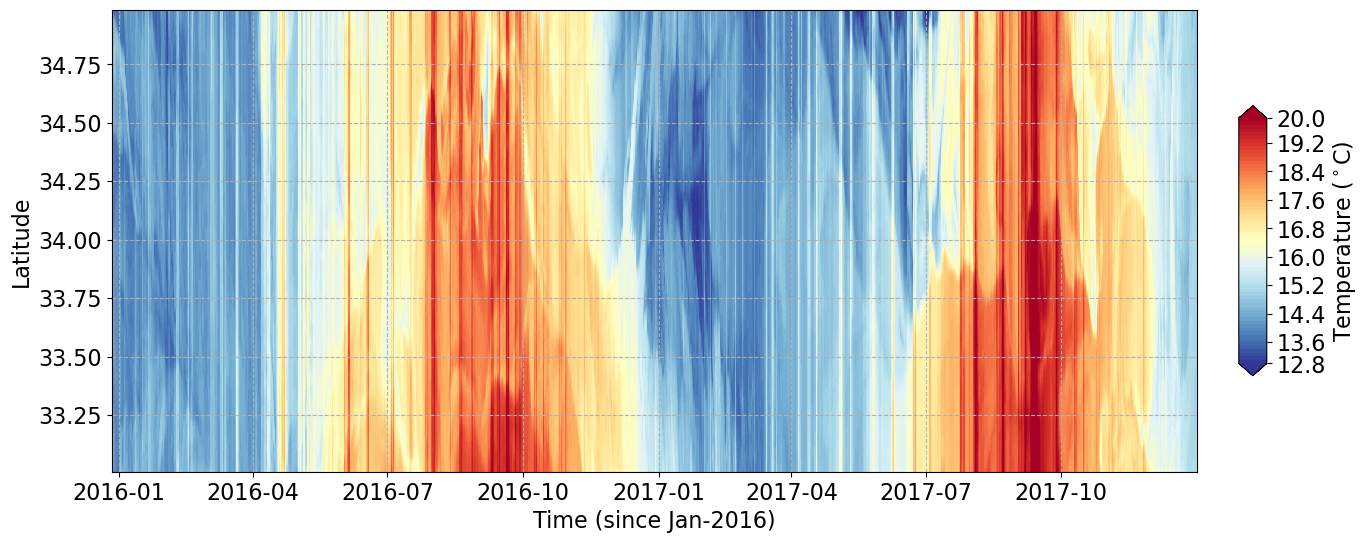

In [29]:
# Specify data specific attributes 
if option_var == 'temp':
    levels = np.arange(13,20,0.1)
elif option_var == 'sal':
    levels = np.arange(32.85,33.75 + 0.02,0.02)
elif option_var == 'density': 
    levels = np.arange(32.85,33.75 + 0.02,0.02)

# Create figure
fig, axes = plt.subplots(1,1, figsize=(14, 6))

# Plot zonal temperature
ctf = axes.contourf(time_dt,lat,data_m.T,cmap='RdYlBu_r',levels=levels,extend='both')

# Create colorbar
cax = plt.axes([0.93, 0.27, 0.02, 0.45])
cart.set_cbar(
    ctf,
    cax,
    fig,
    orientation="vertical",
    extend="both",
    cbar_label=label,
    nbins=10,
    fontsize=fontsize,
    cbar_ticks=[],
    task="regular",
)

# Set the figure attributes 
axes.set_xlabel('Time (since Jan-2016)')
axes.set_ylabel('Latitude')
# axes.set_xlim([time_dt[0], time_dt[1000]])
axes.grid(True, linestyle='--')
plt.show()

Developmental Code

In [5]:
#--- MITgcm Data ---# 
if option_var == 'temp':
    filename_z = PATH + "THETA_CCS4_hrly_zonal.nc"
    filename_m = PATH + "THETA_CCS4_hrly_meridional.nc"
elif option_var == 'sal':
    filename_z = PATH + "SALT_CCS4_hrly_zonal.nc"
    filename_m = PATH + "SALT_CCS4_hrly_meridional.nc"
elif option_var == 'density':
    filename_z = PATH + "RHO_CCS4_hrly_zonal.nc"
    filename_m = PATH + "RHO_CCS4_hrly_meridional.nc"
nc_z = Dataset(filename_z, 'r')
nc_m = Dataset(filename_m, 'r')

# Extract data variables
water_depth_z   = nc_z.variables['Depth'][:]
water_depth_m   = nc_m.variables['Depth'][:]

lon_z = nc_z.variables['XC'][:]
lat_z = nc_z.variables['YC'][:]
time_z =  num2date(nc_z.variables['time'][:], nc_z.variables['time'].units)
lon_m = nc_m.variables['XC'][:]
lat_m = nc_m.variables['YC'][:]
time_m =  num2date(nc_m.variables['time'][:], nc_m.variables['time'].units)

if option_var == 'temp':
    data_z = nc_z.variables['THETA'][:]
    data_m = nc_m.variables['THETA'][:]
elif option_var == 'sal':
    data_z = nc_z.variables['SALT'][:]
    data_m = nc_m.variables['SALT'][:]
elif option_var == 'density':
    data_z = nc_z.variables['RHO'][:]
    data_m = nc_m.variables['RHO'][:]

# Convert cftime.DatetimeGregorian to Python datetime objects
time_dt_z = np.array([datetime(d.year, d.month, d.day, d.hour, d.minute, d.second) for d in time_z])
time_dt_m = np.array([datetime(d.year, d.month, d.day, d.hour, d.minute, d.second) for d in time_m])

# Compute the spatial resolution 
L_z = np.mean(np.diff(lon_z))
L_m = np.mean(np.diff(lat_m))

ValueError: diff requires input that is at least one dimensional

Plot the spatial domain